## NOTEBOOK IMPORTS

In [1]:
import numpy as np
import pandas as pd

from glob import glob
from PIL import Image

import pickle
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## LOADING ALL MODELS

In [2]:
# harrcascade classifier
harr = cv2.CascadeClassifier('./harrcascade-classifier/haarcascade_frontalface_default.xml')

# mean of preprocessed data
XMean = pickle.load(open('./models/XMean.pickle', 'rb'))

# svm model
model_svm = pickle.load(open('./models/SVC_Model.pickle', 'rb'))

# pca model
model_pca = pickle.load(open('./models/PCA_50.pickle', 'rb'))

### THE PIPELINE
    1. Read an image with opencv
    2. Convert to grayscale
    3. Face detection using harrcascascade
    4. Crop face
    5. Normalize, Resize, Flatten
    6. Subtract with mean
    7. Eigen Faces
    8. SVM 
    9. Output

In [3]:
gender = ['Male', 'Female']

# reading image by opencv
def gender_prediction(img, color='rgb'):
    
    # converting to grayscale
    if color == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    # face detection harrcascade classifier    
    faces = harr.detectMultiScale(gray, 1.5, 3)
    
    for x, y, w, h in faces:
        
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # cropping face
        roi = gray[y:y+h, x:x+w]
        
        # normalizing
        roi = roi/255.0
        
        # resize
        if roi.shape[1] > 100:
            roi_resize = cv2.resize(roi, (100, 100), cv2.INTER_AREA)
        else:
            roi_resize = cv2.resize(roi, (100, 100), cv2.INTER_CUBIC)
           
        # reshape --> flatten
        roi_reshape = roi_resize.reshape(1, -1)
        
        # subtracting mean
        roi_mean = roi_reshape - XMean
        
        # eigen faces
        eigen_image = model_pca.transform(roi_mean)
        
        # score prediction by probability
        results = model_svm.predict_proba(eigen_image)[0]
        
        score = results[results.argmax()]
        
        # printing result onto image
        text = "%s : %0.2f"%(gender[results.argmax()], score)
        
        cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
    return img  

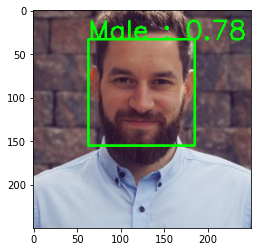

In [4]:
test_image_1 = './test-images/U2.jpg'
test_image_2 = './test-images/U4.jpg'

img = Image.open(test_image_2)
img = np.array(img)
img = gender_prediction(img)
plt.imshow(img)

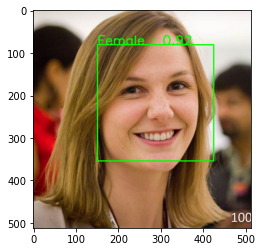

In [5]:

img = Image.open(test_image_1)
img = np.array(img)
img = gender_prediction(img)
plt.imshow(img)

## OPTIONAL: APPLYING TO VIDEO

In [6]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

In [11]:
cap = cv2.VideoCapture('./test-images/test.mp4')

while True:
    
    ret, frame = cap.read() # bgr
    
    if ret == False:
        break
        
    frame = gender_prediction(frame, color='bgr')   
    
    resize = ResizeWithAspectRatio(frame, width=400)# Resize by width OR    
    # resize = ResizeWithAspectRatio(image, height=1280) # Resize by height 
    
    cv2.imshow('Gender Detection', resize)
    
    if cv2.waitKey(20) == 27:
        break
        
cv2.destroyAllWindows()
cap.release()